In [1]:
%matplotlib inline
import numpy as np
import rpy2
from rpy2.robjects import pandas2ri, r as rcall
from scipy.ndimage import convolve
from scipy import ndimage
import matplotlib.pyplot as plt
import pandas as pd
pandas2ri.activate()

from ipywidgets import interact, interactive, widgets, Layout, Button
from IPython.display import Audio, display

In [2]:
import sys
sys.path.append("..") # load package in parent folder
import load_r
load_r.load_rda(from_dir='../../results/')
balance = load_r.get_balance()
returns = load_r.get_returns()
returns_annualized_days = (1+returns)**365-1 #annualized returns

[load_rda] loading "/home/vhcandido/Documents/usp/research/performance/results/RSI/EURUSD_days_.rda"


In [3]:
zlim, zrange = load_r.find_zlim(balance, center=1)
print(zlim, zrange)

[0.64143262 1.35856738] [0.64143262 1.28635164]


In [149]:
from datetime import datetime
dates = np.array(rcall('as.character(bt$dates)'))
dates = np.array([datetime.strptime(d, '%Y-%m-%d') for d in dates])

def format_dates(dates, format='%Y-%m-%d'):
    return np.array([datetime.strftime(d, format) for d in dates])

def get_group_indexes(dates, format='%Y-%m'):
    formatted = format_dates(dates, format=format)
    clusters = []
    for cl in np.unique(formatted):
        idx = np.where(formatted == cl)[0]
        clusters.append(idx)
    return clusters

def apply_over_groups(x, groups, f, *args, **kwargs):
    return np.array([f(x[g], *args, **kwargs) for g in groups])

def format_all_returns(x):    
    groups = get_group_indexes(dates, '%Y-%m')
    return np.apply_along_axis(func1d=apply_over_groups,
                               axis=0, arr=x, groups=groups,
                               f=lambda x: np.prod(x+1)-1)

def format_all_balances(x):    
    groups = get_group_indexes(dates, '%Y-%m')
    return np.apply_along_axis(func1d=apply_over_groups,
                               axis=0, arr=x, groups=groups,
                               f=lambda x: x[-1])


returns_monthly = format_all_returns(returns)
returns_annualized_months = (returns_monthly+1)**12-1

balance_monthly = format_all_balances(balance)
returns_annualized_months = (balance_monthly+1)**12-1

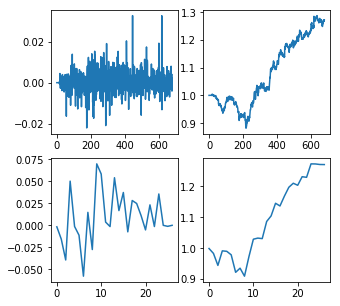

In [31]:
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(221)
ax.plot(returns[:,49,9])

ax = fig.add_subplot(222)
ax.plot(np.cumprod(returns[:,49,9]+1))

ax = fig.add_subplot(223)
ax.plot(returns_monthly[:,49,9])

ax = fig.add_subplot(224)
ax.plot(np.cumprod(returns_monthly[:,49,9]+1))

plt.show()

In [28]:
print(zlim)
months = np.unique(format_dates(dates, '%Y-%m'))
def get_interact(x):
    x = np.copy(x)
    def f(n, j, i):
        zlim, _ = load_r.find_zlim(x, 0)
        print(zlim)
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.imshow(x[n, i[0]:i[1], j[0]:j[1]], vmin=zlim[0], vmax=zlim[1], cmap=plt.cm.jet)
        #ax.imshow(x[n], cmap=plt.cm.jet)
        ax.set_title(months[n])
        plt.show()
    
    w1 = widgets.IntSlider(min=0, max=len(x)-1, step=1,
                           value=len(x)-1, description='Datetime',
                           continuous_update=False,
                           layout=Layout(width='80%', height='30px'))

    w2 = widgets.IntRangeSlider(min=0, max=x.shape[1]-1, step=1,
                                value=[0,x.shape[1]-1], description='Param 1',
                                continuous_update=False, layout=w1.layout)

    w3 = widgets.IntRangeSlider(min=0, max=x.shape[2]-1, step=1,
                                value=[0,x.shape[2]-1], description='Param 2',
                                continuous_update=False, layout=w1.layout)

    return interactive(f, n=w1, i=w3, j=w2)

w = get_interact(returns_annualized_months)
display(w)

[0.64143262 1.35856738]


interactive(children=(IntSlider(value=26, continuous_update=False, description='Datetime', layout=Layout(height='30px', width='80%'), max=26), IntRangeSlider(value=(0, 49), continuous_update=False, description='Param 1', layout=Layout(height='30px', width='80%'), max=49), IntRangeSlider(value=(0, 49), continuous_update=False, description='Param 2', layout=Layout(height='30px', width='80%'), max=49), Output()), _dom_classes=('widget-interact',))

/home/vhcandido/anaconda3/envs/rpy/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


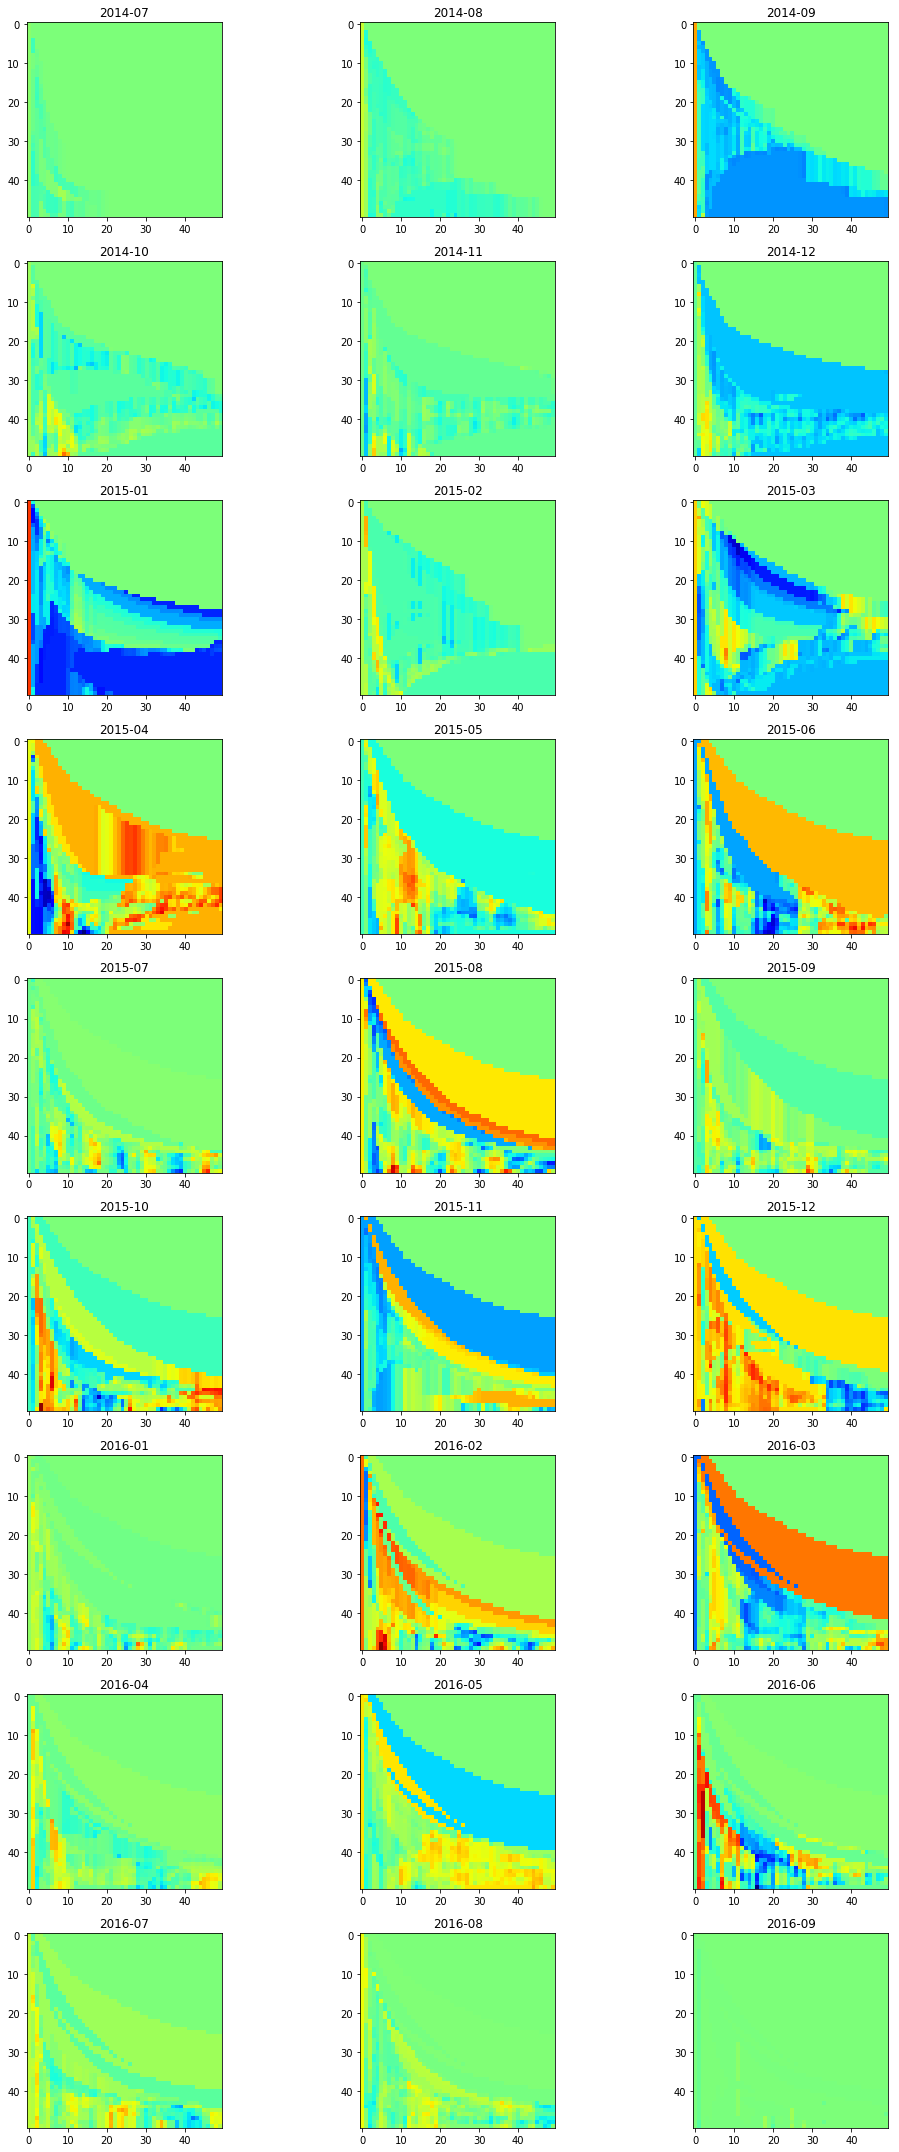

In [25]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15,30), tight_layout=True)
row, col = 9, 3
gs = gridspec.GridSpec(row, col)
def plot(x, zlim=None):
    if zlim is None:
        zlim, _ = load_r.find_zlim(x, 0)
    for k, n in enumerate(range(len(x))):
        i = k // col
        j = k % col
        ax = fig.add_subplot(gs[i, j])
        #ax.imshow(returns_annualized_months[n], cmap = plt.cm.jet)
        ax.imshow(x[n], vmin=zlim[0], vmax=zlim[1], cmap=plt.cm.jet)
        ax.set_title(months[n])

plot(returns_monthly)
plt.show()

(680, 50, 50)
Best: 2459 | i = 49 | j = 9


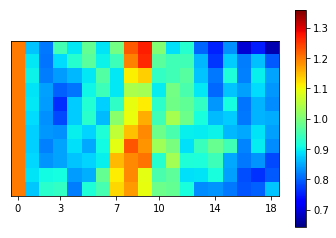

In [32]:
shape = balance.shape
print(shape)

off = 10
def find_max_idx(x):
    k = np.nanargmax(x)
    ncol = x.shape[1]
    return k, k/ncol, k%ncol
k, i, j = find_max_idx(balance[-1])
print('Best: %d | i = %d | j = %d' % (k,i,j))

ii = np.arange(max(0, i-off), min(shape[1], i+off), dtype=np.int8)
jj = np.arange(max(0, j-off), min(shape[2], j+off), dtype=np.int8)

t_ii = np.linspace(start=0, stop=len(ii)-1, num=6, dtype=np.int8)
t_jj = np.linspace(start=0, stop=len(jj)-1, num=6, dtype=np.int8)
plt.yticks(ii[t_ii])
plt.xticks(jj[t_jj])

jj_, ii_ = np.meshgrid(jj, ii)
plt.imshow(balance[-1, ii_, jj_], origin='lower',
           vmin=zlim[0], vmax=zlim[1],
           cmap=plt.cm.jet)
plt.colorbar()

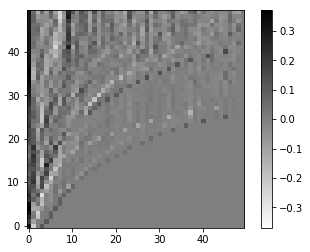

In [33]:
def mean_mask(n):
    n2 = n**2
    return np.array([1]*n2).reshape(n,n)/n2

masks = {}
masks['example'] = np.array([[1,1,1], [1,1,0], [1,0,0]])/6
masks['mean3'] = np.array([[.2,.2,.2], [.2,.2,.2], [.2,.2,.2]])
masks['edge1'] = np.array([[0,0,0], [-1,1,0], [0,0,0]])
masks['edge2'] = np.array([[0,-1,0], [-1,4,-1], [0,-1,0]])
masks['emboss'] = np.array([[-2,-1,0], [-1,1,1], [0,1,2]]) # relevo

r = convolve(balance[-1], masks['edge1'])

zlim_, _ = load_r.find_zlim(r)
if(load_r.mode(r) == 0):
    cmap = plt.cm.gray_r
else:
    cmap = plt.cm.jet
    
plt.imshow(r, origin='lower', cmap=cmap,
           vmin=zlim_[0], vmax=zlim_[1])
           #cmap=plt.cm.jet, interpolation='none')
plt.colorbar()

/home/vhcandido/anaconda3/envs/rpy/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


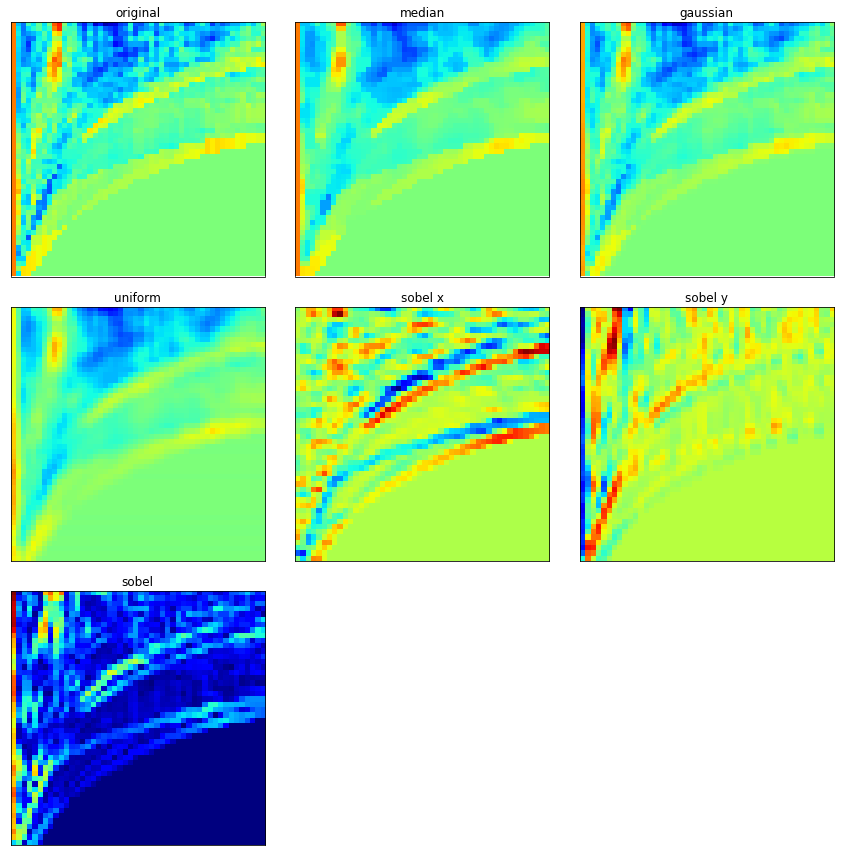

In [36]:
#http://www.scipy-lectures.org/advanced/image_processing/
b = np.copy(balance[-1])

fig = plt.figure(tight_layout=True, figsize=(12,12))
gs = gridspec.GridSpec(3, 3)

def plott(im, title, pos, col=3, center=True, cmap=plt.cm.jet):
    ax = fig.add_subplot(pos)
    if center:
        ax.imshow(im, origin='lower', cmap=cmap, vmin=zlim[0], vmax=zlim[1])
    else:
        #zlim2, _ = load_r.find_zlim(im)
        #plt.imshow(im, origin='lower', cmap=plt.cm.jet, vmin=zlim2[0], vmax=zlim2[1])
        ax.imshow(im, origin='lower', cmap=cmap)
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xticks([])

plott(b, 'original', gs[0,0])

im = ndimage.median_filter(b, 3)
plott(im, 'median', gs[0,1])

im = ndimage.gaussian_filter(b, sigma=.5)
plott(im, 'gaussian', gs[0,2])

im = ndimage.uniform_filter(b, size=3)
plott(im, 'uniform', gs[1,0])

sx = ndimage.sobel(b, axis=0, mode='constant')
plott(sx[1:-1, 1:-1],  'sobel x', gs[1,1],center=False)

sy = ndimage.sobel(b, axis=1, mode='constant')
plott(sy[1:-1, 1:-1], 'sobel y', gs[1,2], center=False)

sob = np.hypot(sx, sy)
plott(sob[1:-1, 1:-1], 'sobel', gs[2,0], center=False)

#plt.subplots_adjust(wspace=0.02, hspace=0.5, top=.9, bottom=.1, left=.1, right=0.9)


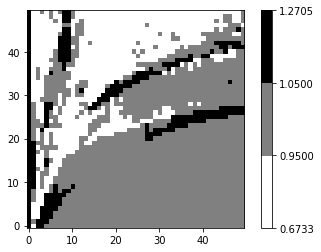

In [37]:
r = np.copy(balance[-1])
_, zrange_ = load_r.find_zlim(r)
m = load_r.mode(r)

from matplotlib import colors
cmap = colors.ListedColormap(['white', 'gray', 'black'])
bounds = [zrange_[0], m*.95, m*1.05, zrange_[1]]
#bounds_ = [zlim_[0], m, zlim_[1]]
norm = colors.BoundaryNorm(bounds, cmap.N)

plt.imshow(r, origin='lower', cmap=cmap, norm=norm)
plt.colorbar()
#plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)

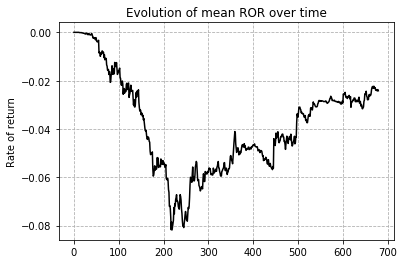

In [104]:

means = np.apply_over_axes(func=np.mean, a=balance-1, axes=[1,2]).reshape(-1)
plt.plot(np.arange(len(means)), means, color='black')
plt.grid(linestyle='--')
plt.title('Evolution of mean ROR over time')
plt.ylabel('Rate of return')
plt.show()


In [161]:
def semi_std(x, target=None):
    if target is None:
        target = np.mean(x)
    i = np.where(x < target)
    if len(x[i]) == 0: return 0.0
    return np.sqrt(np.sum((x[i] - target)**2)/len(x))

def semi_std_series(x_, target=None):
    l = []
    for i in np.arange(1, len(x_)+1):
        x = x_[np.arange(i)]
        if target is None:
            target = np.mean(x)
        i = np.where(x < target)
        if len(x[i]) == 0:
            l.append(0.0)
        else:
            l.append(np.sqrt(np.sum((x[i] - target)**2)/len(x)))
    return np.array(l)

def std_series(x_):
    l = []
    for i in np.arange(1, len(x_)+1):
        l.append(np.std(x_[np.arange(i)]))
    return np.array(l)

std_all1 = np.apply_along_axis(func1d=std_series, axis=0, arr=returns_monthly)
std_all2 = np.apply_along_axis(func1d=semi_std_series, axis=0, arr=returns_monthly, target=0)

#print(semi_std(x))
#print(semi_std(x, 0))
#print(semi_std(x, -.5))
#print('')
#print(semi_std(np.array([-10,0,0])))
#print(semi_std(np.array([-10,0,0]), 0))
#print('')
#print(semi_std(np.array([-10,-10,-10])))
#print(semi_std(np.array([-10,-10,-10]), 0))
#print('')
#print(semi_std(np.array([-10,-5,0])))
#print(semi_std(np.array([-10,-5,0]), 0))
#print('')
#print(semi_std(np.array([-10,-5,-5])))
#print(semi_std(np.array([-10,-5,-5]), 0))

b_annual = np.apply_along_axis(func1d=lambda x: x ** (12/int(x.shape[0]))-1, axis=0, arr=balance_monthly)
#last_b_annual = balance[-1]**(365/balance.shape[0]) - 1

xlim, _ = load_r.find_zlim(b_annual, 0)
_, ylim1 = load_r.find_zlim(std_all1)
_, ylim2 = load_r.find_zlim(std_all2)

# dados fundamentalistas
# https://queroficarrico.com/blog/ferramentas-gratuitas-para-analise-fundamentalista/
# instituto asaf
# fundamentos.com.br

In [163]:

def foo(i):
    fig = plt.figure(figsize=(10,10), dpi=100, tight_layout=True)
    
    ax = fig.add_subplot(311)
    sd1_ = std_all1[i]
    sd1_[np.where(sd1_ == 0)] = None
    ax.set_xlabel('Annualized ROR')
    ax.set_ylabel('stdev')
    ax.set_title(months[i])
    line1 = ax.scatter(b_annual[i], sd1_, s=15, alpha=.2)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim1[0], ylim1[1])
    #line = ax.plot(balance[-1], sd1, 'bo', alpha=.1, markersize=3, picker=3)
    ax.grid(linestyle='--')

    ax = fig.add_subplot(312)
    sd2_ = std_all2[i]
    sd2_[np.where(sd2_ == 0)] = None
    line2 = ax.scatter(b_annual[i], sd2_, s=15, alpha=.2)
    ax.set_xlabel('Annualized ROR')
    ax.set_ylabel('semidev')
    ax.set_title(months[i])
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_ylim(ylim2[0], ylim2[1])
    ax.grid(linestyle='--')
    
    plt.show()

x = widgets.IntSlider(min=0, max=len(std_all1)-1, step=1, value=len(std_all1)-1, continuous_update=False)
interact(foo, i=x)

interactive(children=(IntSlider(value=26, continuous_update=False, description='i', max=26), Output()), _dom_classes=('widget-interact',))

<function __main__.foo>

In [ ]:
from ipywidgets import interact, interactive, widgets
from IPython.display import Audio, display

zlim_sd2 = load_r.find_zlim(sd2)[0]
def f(n):
    plt.scatter(balance[n].reshape(-1), sd2.reshape(-1), s=10, alpha=.25)
    #plt.ylim(*zlim_sd2)
    #plt.xlim(*zlim)
    #plt.grid(linestyle='--')
    plt.show()
    
w = widgets.IntSlider(min=0, max=balance.shape[0]-1, step=5,
                      value=balance.shape[0]-1,
                      description='Datetime', continuous_update=False)
wid = interactive(f, n=w)

cl |  mean | size
 0 | 0.838 | 329
 1 | 0.927 | 529
 2 | 1.000 | 1321
 3 | 1.075 | 256
 4 | 1.198 | 65


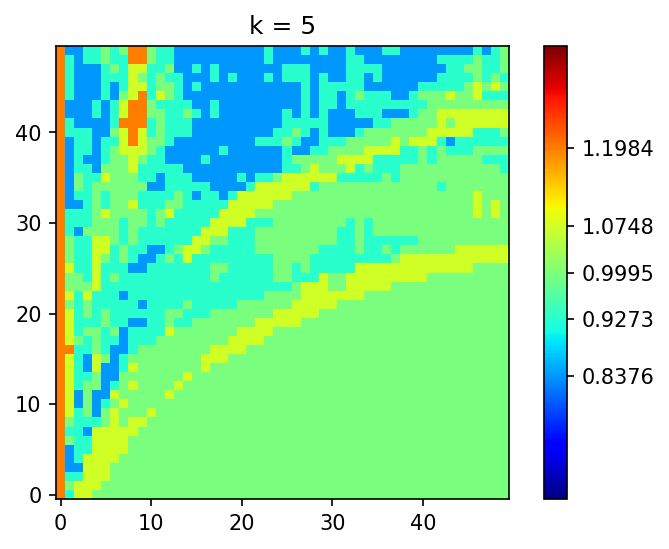

In [61]:
k = 5
def get_cluster_indexes(x, k = 5):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=k, random_state=0).fit(x.reshape(-1,1))
    clusters = []
    for cl in np.unique(kmeans.labels_):
        idx = np.where(kmeans.labels_ == cl)[0]
        clusters.append(idx)
    return clusters

b = balance[-1].reshape(-1)
cluster_idx_list = get_cluster_indexes(b, k)

def get_clusterized_array(x, clusters):
    print('cl |  mean | size')
    sorted_cl_idx = np.argsort([np.mean(x[idx]) for idx in clusters])
    for i, cl in enumerate(sorted_cl_idx):
        idx = clusters[cl]
        mean = np.mean(x[idx])
        x[idx] = mean
        print('%2d | %.3f | %d' % (i, mean, len(idx)))
    return x

b = get_clusterized_array(b, cluster_idx_list)

fig = plt.figure(dpi=150)#figsize = (12,12))
ax = fig.add_subplot(111)
img = ax.imshow(b.reshape(balance[-1].shape), cmap=plt.cm.jet, origin='lower', vmin=zlim[0], vmax=zlim[1])
ax.set_title('k = %d' % k)
#plt.colorbar()
fig.colorbar(img, ticks = np.unique(b))
#plt.colorbar(img, cmap=cmap, norm=norm, boundaries=bounds, ticks=bounds)
plt.show()

In [128]:
10/np.arange(10).shape[0]

1.0